This code is heavily inspired from [Sebastian Raschka](https://x.com/rasbt)'s excellent book, "[Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)".

I highly recommend buying and reading that book.

My code here is taken directly from Sebastian's book, but with some slight variable and styling updates.

Questions?  Feel free to DM me on [Twitter](https://x.com/virattt).

In [1]:
!pip install tensorflow>=2.15.0  tqdm>=4.66 tiktoken --quiet

## 1. Download GPT-2 weights

In [2]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x79129ac2a5c0>)

In [3]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 49.9kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.88MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 38.2kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:21<00:00, 22.8MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 3.50MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.38MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.30MiB/s]


## 2. Inspect the model

In [4]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


## 3. Set model configuration

In [5]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [6]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [7]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [8]:
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})

## 4. Implement layer normalization module

In [9]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    normalized_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * normalized_x + self.shift

## 5. Define multi-head attention block

In [10]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()

    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out                  # 768
    self.num_heads = num_heads          # 12
    self.head_dim = d_out // num_heads  # 64
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(
            context_length,             # 1024
            context_length,             # 1024
          ), diagonal=1)
    )

  def forward(self, x):
    batch_size, num_tokens, embedding_length = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # Add the num_heads and head_dim dimensions
    keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)       # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64
    queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim) # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64
    values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim)   # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64

    # Transpose from (batch_size, num_tokens, num_heads, head_dim) to (batch_size, num_heads, num_tokens, head_dim)
    queries = queries.transpose(1, 2)
    keys = keys.transpose(1, 2)
    values = values.transpose(1, 2)

    # Calculate attention scores
    attention_scores = queries @ keys.transpose(2, 3)
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

    # Mask the attention scores
    attention_scores.masked_fill_(mask_bool, -torch.inf)

    # Calculate attention weights
    attention_weights = torch.softmax(attention_scores / keys.shape[-1]**0.5, dim=-1)

    # Apply dropout to attention weights
    attention_weights = self.dropout(attention_weights)

    # Calculate context vectors
    context_vectors = (attention_weights @ values).transpose(1, 2)

    # Concatenate the context vectors
    context_vectors = context_vectors.contiguous().view(batch_size, num_tokens, self.d_out)
    return self.out_proj(context_vectors)

## 6. Implement feed-forward network

In [11]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [12]:
# Implement feed-forward neural network
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
        GELU(),
        nn.Linear(4 * config["emb_dim"], config["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

## 7. Implement transformer block

In [13]:
class TransformerBlock(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.attention = MultiHeadAttention(
        d_in=config["emb_dim"],
        d_out=config["emb_dim"],
        context_length=config["context_length"],
        dropout=config["drop_rate"],
        num_heads=config["n_heads"],
        qkv_bias=config["qkv_bias"]
    )

    self.ff = FeedForward(config)
    self.norm1 = LayerNorm(config["emb_dim"])
    self.norm2 = LayerNorm(config["emb_dim"])
    self.drop_shortcut = nn.Dropout(config["drop_rate"])

  def forward(self, x):
    shortcut = x

    # Attention layer
    x = self.norm1(x)
    x = self.attention(x)
    x = self.drop_shortcut(x)
    x = x + shortcut         # Add the original input back

    # Feedforward layer
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut         # Add the original input back
    return x

## 8. Implement GPT model

In [14]:
class GPTModel(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.token_embedding = nn.Embedding(config["vocab_size"], config["emb_dim"])
    self.positional_embedding = nn.Embedding(config["context_length"], config["emb_dim"])
    self.drop_embedding = nn.Dropout(config["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(config) for _ in range(config["n_layers"])]
    )

    self.final_norm = LayerNorm(config["emb_dim"])
    self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, sequence_length = in_idx.shape
    token_embeddings = self.token_embedding(in_idx)
    positional_embeddings = self.positional_embedding(
        torch.arange(sequence_length, device=in_idx.device)
    )
    x = token_embeddings + positional_embeddings
    x = self.drop_embedding(x)

    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

## 9. Implement function for loading weights

In [15]:
# Load the weights
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                          "Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.positional_embedding.weight = assign(gpt.positional_embedding.weight, params['wpe'])
    gpt.token_embedding.weight = assign(gpt.token_embedding.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].attention.W_query.weight = assign(
            gpt.trf_blocks[b].attention.W_query.weight, q_w.T)
        gpt.trf_blocks[b].attention.W_key.weight = assign(
            gpt.trf_blocks[b].attention.W_key.weight, k_w.T)
        gpt.trf_blocks[b].attention.W_value.weight = assign(
            gpt.trf_blocks[b].attention.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].attention.W_query.bias = assign(
            gpt.trf_blocks[b].attention.W_query.bias, q_b)
        gpt.trf_blocks[b].attention.W_key.bias = assign(
            gpt.trf_blocks[b].attention.W_key.bias, k_b)
        gpt.trf_blocks[b].attention.W_value.bias = assign(
            gpt.trf_blocks[b].attention.W_value.bias, v_b)

        gpt.trf_blocks[b].attention.out_proj.weight = assign(
            gpt.trf_blocks[b].attention.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].attention.out_proj.bias = assign(
            gpt.trf_blocks[b].attention.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

## 10. Implement model helper functions

In [17]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [18]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    # .unsqueeze(0) adds the batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # Remove batch dimension
    return tokenizer.decode(flat.tolist())

tokenizer = tiktoken.get_encoding("gpt2")

## 11. Download finetuning dataset

In [19]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [20]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [25]:
# Examine class distributions
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [26]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [27]:
# Convert the "Label" column into 0 or 1 (for "ham" or "spam")
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [28]:
# Split the dataset into train, test, val
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)


    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [29]:
# Save dataset as CSV for reuse later
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## 12. Create dataloaders

In [30]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [31]:
# Create the dataset

import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
  def __init__(self, csv_file, tokenizer, max_length=1024, pad_token_id=50256):
    self.data = pd.read_csv(csv_file)

    # Encode the input text
    self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]

    # Determine max length of encoded texts
    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length
      # Truncate any texts longer than max_length
      self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]

    # Pad the encoded texts
    self.encoded_texts = [
        encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
        for encoded_text in self.encoded_texts
    ]

  def __getitem__(self, index):
     encoded_text = self.encoded_texts[index]
     label = self.data.iloc[index]["Label"]
     return (
         torch.tensor(encoded_text, dtype=torch.long),
         torch.tensor(label, dtype=torch.long)
     )

  def __len__(self):
    return len(self.data)

  def _longest_encoded_length(self):
    max_length = 0
    for encoded_text in self.encoded_texts:
      encoded_length = len(encoded_text)
      max_length = max(max_length, encoded_length)
    return max_length

In [32]:
# Create a train dataset
train_dataset = SpamDataset(
    csv_file="train.csv",
    tokenizer=tokenizer,
    max_length=None
)

# Create a validation dataset
validation_dataset = SpamDataset(
    csv_file="validation.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)

# Create a test dataset
test_dataset = SpamDataset(
    csv_file="test.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)

In [33]:
print(train_dataset.max_length)

120


In [34]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

# Create training set DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

# Create validation set DataLoader
val_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

# Create test set DataLoader
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

In [35]:
# Ensure DataLoaders are working as expected
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [36]:
# Check total number of batches in each dataset
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## 13. Load the pretrained model

In [37]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [38]:
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (token_embedding): Embedding(50257, 768)
  (positional_embedding): Embedding(1024, 768)
  (drop_embedding): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(


In [39]:
text_1 = "Every effort moves you"
token_ids = generate(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [40]:
# Test if model can already classify spam messages (without finetuning)
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


## 14. Implement a classification head

In [41]:
# Freeze all model layers first
for param in model.parameters():
  param.requires_grad = False

In [42]:
# Add a classification head
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"], # 768
    out_features=num_classes,           # 2 (spam or not spam)
)

In [43]:
# Make the final transformer block trainable
for param in model.trf_blocks[-1].parameters():
  param.requires_grad = True

# Make the final LayerNorm trainable
for param in model.final_norm.parameters():
  param.requires_grad = True

In [44]:
# Test out the classification head!
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)

with torch.no_grad():
  outputs = model(inputs)

print(f"Outputs:\n {outputs}")
print(f"Outputs dimensions: {outputs.shape}")



Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [45]:
# Get the classification prediction, which is the last token in the output
print(f"Last output token: {outputs[:, -1, :]}")

Last output token: tensor([[-3.5983,  3.9902]])


## 15. Implement loss functions

In [46]:
def calculate_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)[:, -1, :] # Grab logits of last output token only!
  loss = torch.nn.functional.cross_entropy(logits, target_batch)
  return loss

In [47]:
def calculate_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  # Loop through data loader and calculate loss
  for index, (input_batch, target_batch) in enumerate(data_loader):
    if index < num_batches:
      loss = calculate_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Calculate loss of each loader
with torch.no_grad():
  train_loss = calculate_loss_loader(train_loader, model, device, num_batches=5)
  val_loss = calculate_loss_loader(val_loader, model, device, num_batches=5)
  test_loss = calculate_loss_loader(test_loader, model, device, num_batches=5)


In [50]:
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.183
Validation loss: 2.583
Test loss: 2.322


## 16. Implement evaluation functions

In [51]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  # Put model in evaluation mode
  model.eval()
  with torch.no_grad():
    train_loss = calculate_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calculate_loss_loader(val_loader, model, device, num_batches=eval_iter)

  # Put model back in training mode
  model.train()
  return train_loss, val_loss

In [52]:
def calculate_accuracy_loader(data_loader, model, device, num_batches=None):
  # Put model in evaluation mode
  model.eval()
  correct_predictions, num_examples = 0, 0

  if num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for index, (input_batch, target_batch) in enumerate(data_loader):
    if index < num_batches:
      input_batch, target_batch = input_batch.to(device), target_batch.to(device)

      with torch.no_grad():
        logits = model(input_batch)[:, -1, :] # Last output token only
      predicted_labels = torch.argmax(logits, dim=-1)

      num_examples += predicted_labels.shape[0]
      correct_predictions += (predicted_labels == target_batch).sum().item()

  return correct_predictions / num_examples


## 17. Implement finetuning function

In [53]:
def train_classifier(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    tokenizer,
  ):

  # Initialize lists to track losses and examples seen
  train_losses, val_losses, train_accs, val_accs = [], [], [], []
  examples_seen, global_step = 0, -1

  # Main training loop
  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calculate_loss_batch(input_batch, target_batch, model, device)
      loss.backward()
      optimizer.step()
      examples_seen += input_batch.shape[0]
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(
          model, train_loader, val_loader, device, eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
              )
    train_accuracy = calculate_accuracy_loader(
        train_loader, model, device, num_batches=eval_iter
    )

    val_accuracy = calculate_accuracy_loader(
        val_loader, model, device, num_batches=eval_iter
    )

    print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")

    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)
  return train_losses, val_losses, train_accs, val_accs, examples_seen

## 18. Train the model!

In [54]:
import time

start_time = time.time()
torch.manual_seed(123)

# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

# Set training epochs
num_epochs = 5

# Train the model
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=50,
    eval_iter=5,
    tokenizer=tokenizer,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 0.94 mi

## 19. Visualize the training loss

In [55]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))


    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()


    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

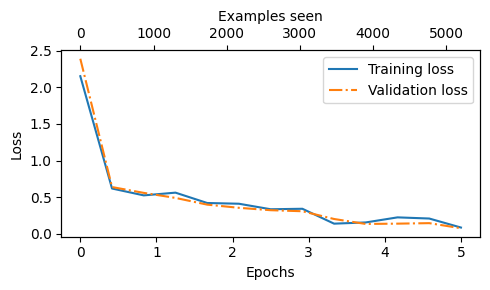

In [56]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

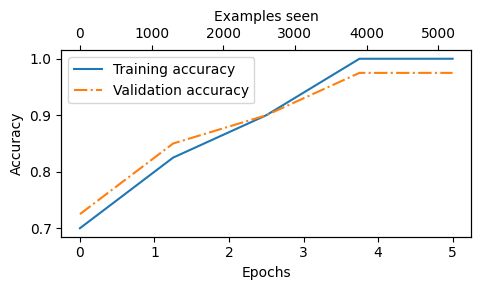

In [57]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [58]:
train_accuracy = calculate_accuracy_loader(train_loader, model, device)
val_accuracy = calculate_accuracy_loader(val_loader, model, device)
test_accuracy = calculate_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


## 20. Use the fintuned model

In [59]:
def classify(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.positional_embedding.weight.shape[1]

    input_ids = input_ids[:min(max_length, supported_context_length)]

    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)


    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [60]:
texts = [
    # Spam examples
    "!!FREE ROLEX!! Click NOW! 1,000,000th visitor! YOU WON!!!",
    "V1AGR@ & C1AL1S 90% OFF!!! BEST DEAL EVER!!! BUY NOW!!!",
    "$$$MAKE MONEY FAST$$$ Work 1 hr/day! Earn $50k/week GUARANTEED!!!",

    # Non-spam examples
    "Q3 Financial Report: Please review and submit feedback by Friday",
    "Mandatory security training: Complete by end of month to maintain system access",
    "Office closure notice: Building maintenance scheduled for 7/15, work remotely"
]

In [61]:
for text in texts:
  print(f"Text: {text}")
  print(f"Classification: {classify(text, model, tokenizer, device, max_length=train_dataset.max_length)}")
  print()

Text: !!FREE ROLEX!! Click NOW! 1,000,000th visitor! YOU WON!!!
Classification: spam

Text: V1AGR@ & C1AL1S 90% OFF!!! BEST DEAL EVER!!! BUY NOW!!!
Classification: spam

Text: $$$MAKE MONEY FAST$$$ Work 1 hr/day! Earn $50k/week GUARANTEED!!!
Classification: spam

Text: Q3 Financial Report: Please review and submit feedback by Friday
Classification: not spam

Text: Mandatory security training: Complete by end of month to maintain system access
Classification: not spam

Text: Office closure notice: Building maintenance scheduled for 7/15, work remotely
Classification: not spam

